In [61]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import lightning as L
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
class BasicLightning(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)

    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias

        output = F.relu(input_to_final_relu)

        return output 


tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0100, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])


<Axes: xlabel='None'>

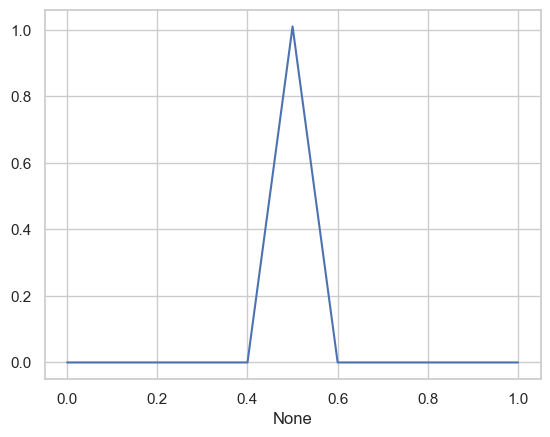

In [63]:
input_doses = torch.linspace(start=0, end=1, steps=11)
print(input_doses)

model = BasicLightning()

output_values = model(input_doses)

print(output_values)

sns.set(style="whitegrid")

sns.lineplot(x=input_doses, y=output_values.detach().numpy())

In [64]:
class BasicLightningTrain(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.learning_rate = 0.01

    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias

        output = F.relu(input_to_final_relu)

        return output

    def configure_optimizers(self):
        return SGD(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch    
        output_i = self.forward(input_i)
        loss = (output_i - label_i)**2
        
        return loss
    


In [65]:

inputs = torch.tensor([0., 0.5, 1.])
labels = torch.tensor([0., 1., 0.])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

model = BasicLightningTrain()

trainer = L.Trainer(max_epochs=66)

lr_find_results = trainer.tune(model, train_dataloaders=dataloader, min_lr=0.0001, max_lr=1.0, early_stop_threshold=None)

new_lr = lr_find_results.suggestion()

print(f"lr_find suggested learning rate: {new_lr}")

model.learning_rate = new_lr

trainer.fit(model, train_dataloaders=dataloader)

print(model.final_bias.data)



TypeError: Trainer.__init__() got an unexpected keyword argument 'auto_lr_find'